In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import graph_analysis, data_preprocessing

import numpy as np
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
import pandas as pd
import bct
from collections import defaultdict
import tqdm
%matplotlib inline

# Volumetric data

In [21]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')
feature_names_volumetric=european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]

#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

covariates=np.concatenate((StandardScaler().fit_transform(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc']]),LabelBinarizer().fit_transform(european_diffusion_dataset_term['Gender'])),axis=1)


high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)

X_total=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]),covariates)

X_low_risk=X_total[low_risk,:]
X_high_risk=X_total[high_risk,:]

In [5]:
from sklearn.preprocessing import StandardScaler,LabelBinarizer

In [22]:
high_risk_corr_matrix=np.corrcoef(X_high_risk,rowvar=False)
low_risk_corr_matrix=np.corrcoef(X_low_risk,rowvar=False)
high_risk_corr_matrix=0.5*(np.log(1+high_risk_corr_matrix)-np.log(1-high_risk_corr_matrix))#convert to z score
np.fill_diagonal(high_risk_corr_matrix,0)
low_risk_corr_matrix=0.5*(np.log(1+low_risk_corr_matrix)-np.log(1-low_risk_corr_matrix))#convert to z score
np.fill_diagonal(low_risk_corr_matrix,0)

<ipython-input-22-3b80984c771d>:3: RuntimeWarning: divide by zero encountered in log
  high_risk_corr_matrix=0.5*(np.log(1+high_risk_corr_matrix)-np.log(1-high_risk_corr_matrix))#convert to z score
<ipython-input-22-3b80984c771d>:5: RuntimeWarning: divide by zero encountered in log
  low_risk_corr_matrix=0.5*(np.log(1+low_risk_corr_matrix)-np.log(1-low_risk_corr_matrix))#convert to z score


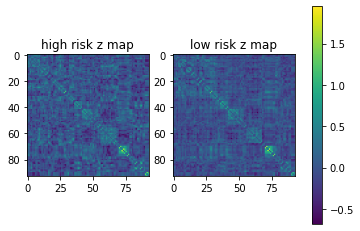

In [7]:
f,axes=plt.subplots(1,2)
im1=axes[0].imshow(high_risk_corr_matrix)
axes[0].set_title('high risk z map')
im2=axes[1].imshow(low_risk_corr_matrix)
axes[1].set_title('low risk z map')
f.colorbar(im1,ax=axes.ravel().tolist())

repeating similar work done by Shi et al., 2012, use bctpy library to check for metrics networks

In [24]:
dict_result_high_risk=defaultdict(dict)
dict_result_low_risk=defaultdict(dict)
for sparsity in tqdm.tqdm(range(1,31)):
    temp_corr_matrix_high_risk = graph_analysis.binarize_matrix_based_on_sparsity_threshold(high_risk_corr_matrix,sparsity/100)

    temp_corr_matrix_low_risk = graph_analysis.binarize_matrix_based_on_sparsity_threshold(low_risk_corr_matrix,sparsity/100)

    original_network_metrics_high, random_network_metrics_high = graph_analysis.calculate_network_metrics_bin_und(temp_corr_matrix_high_risk)
    
    original_network_metrics_low, random_network_metrics_low = graph_analysis.calculate_network_metrics_bin_und(temp_corr_matrix_low_risk)

    dict_result_high_risk[sparsity]['obs']=original_network_metrics_high
    dict_result_high_risk[sparsity]['rand']=random_network_metrics_high
    
    dict_result_low_risk[sparsity]['obs']=original_network_metrics_low
    dict_result_low_risk[sparsity]['rand']=random_network_metrics_low

100%|██████████| 30/30 [05:44<00:00, 11.50s/it]


In [7]:
class analyse_graph:
    def __init__(self,low_risk_corr_matrix,high_risk_corr_matrix):
        self.low_risk_corr_matrix=low_risk_corr_matrix
        self.high_risk_corr_matrix=high_risk_corr_matrix

    def network_metrics(self,sparsity_range=range(5,7)):

        for sparsity in tqdm.tqdm(sparsity_range):
            
            temp_corr_matrix_high_risk = graph_analysis.binarize_matrix_based_on_sparsity_threshold(self.high_risk_corr_matrix,sparsity/100)

            temp_corr_matrix_low_risk = graph_analysis.binarize_matrix_based_on_sparsity_threshold(self.low_risk_corr_matrix,sparsity/100)
            
            #high risk
            original_network_metrics_high, random_network_metrics_high = graph_analysis.calculate_network_metrics_bin_und(temp_corr_matrix_high_risk)

            temp_path_high_risk='./perm_graph_metrics_high_risk_vol.txt'
            with open(temp_path_high_risk,'ab') as f:
                np.savetxt(f,np.concatenate([original_network_metrics_high,random_network_metrics_high]).reshape(1,-1),delimiter='\t')

            #low risk
            original_network_metrics_low, random_network_metrics_low = graph_analysis.calculate_network_metrics_bin_und(temp_corr_matrix_low_risk)

            temp_path_low_risk='./perm_graph_metrics_low_risk_vol.txt'
            with open(temp_path_low_risk,'ab') as f:
                np.savetxt(f,np.concatenate([original_network_metrics_low,random_network_metrics_low]).reshape(1,-1),delimiter='\t')

In [8]:
analyse_graph(low_risk_corr_matrix,high_risk_corr_matrix).network_metrics()

100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


In [11]:
np.save('adjusted_prs_score.npy',adjusted_prs_score)

In [13]:
!ls 

1_dHCP_data_preprocessing.ipynb        X_low_risk_reduced.csv
2_1_dHCP_data_exploration.Rmd          X_total.npy
2_1_dHCP_data_exploration.nb.html      adjusted_prs_score.npy
2_dHCP_data_exploration.ipynb          dataset
3_1_dHCP_graph.ipynb                   log
3_1_dHCP_graph_matlab.mlx              perm_graph_metrics_high_risk_vol.txt
3_2_dHCP_NBS.ipynb                     perm_graph_metrics_low_risk_vol.txt
3_3_dHCP_graph_analysis.ipynb          preprocessed_data
3_dHCP_graph_analysis.ipynb            reduced_european_diffusion_dataset.csv
4_dHCP_diffMRI.ipynb                   result.txt
5_1_dHCP_model_training.ipynb          test.txt
5_dHCP_model_training.ipynb            volumetric_corr_matrix.txt


In [15]:
high_risk_perm=np.loadtxt('perm_graph_metrics_high_risk_vol.txt')
low_risk_perm=np.loadtxt('perm_graph_metrics_low_risk_vol.txt')

In [17]:
high_risk_perm=high_risk_perm[:,0:4]
low_risk_perm=low_risk_perm[:,0:4]

In [27]:
high_risk_obsv=np.asarray([dict_result_high_risk[i]['obs'] for i in range(1,31)])
low_risk_obsv=np.asarray([dict_result_low_risk[i]['obs'] for i in range(1,31)])

In [40]:
high_risk_perm[29::30].shape

(1000, 4)

In [45]:
between_group_difference=abs(high_risk_perm-low_risk_perm)
obsv_difference=abs(high_risk_obsv-low_risk_obsv)
p_value_matrix=np.zeros((30,4))
for network_sparsity_threshold in range(30): #30 thresholds
    for metric in range(4):# 5 metrics
        p_value_matrix[network_sparsity_threshold,metric]=len(np.where(between_group_difference[network_sparsity_threshold::30,metric]>=obsv_difference[network_sparsity_threshold,metric])[0])/1000

<ipython-input-45-f7cb0e8b7a4e>:1: RuntimeWarning: invalid value encountered in subtract
  between_group_difference=abs(high_risk_perm-low_risk_perm)
<ipython-input-45-f7cb0e8b7a4e>:2: RuntimeWarning: invalid value encountered in subtract
  obsv_difference=abs(high_risk_obsv-low_risk_obsv)


In [47]:
test1=np.asarray([dict_result_high_risk[i]['obs'] for i in range(5,25)])
test2=np.asarray([dict_result_low_risk[i]['obs'] for i in range(5,25)])
test3=np.asarray([dict_result_high_risk[i]['rand'] for i in range(5,25)])
test4=np.asarray([dict_result_low_risk[i]['rand'] for i in range(5,25)])

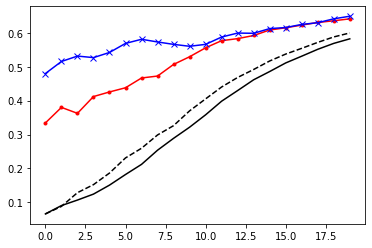

In [50]:
plt.plot(test1[:,1],'r.-',label='high risk')
plt.plot(test2[:,1],'bx-',label='low risk')
plt.plot(test3[:,1],'k-',label='high risk r')
plt.plot(test4[:,1],'k--',label='low risk r')

In [ ]:
def calculate_measures_weighted(G):
    """
    Input:
        G (array): undirected, weighted array
    Returns:
        Eglobal, Elocal, clustering, shortest path average, small worldness
    """
    _,nodes,edges=bct.density_und(G)

    average_path,Eglob,_,_,_=bct.charpath(bct.distance_dir(abs(1/G))
    clustering=bct.clustering_coef_bu(G)
    average_Elocal=np.mean(bct.efficiency_bin(G,1))

    synthetic_und_random_network=bct.makerandCIJ_und(nodes,edges)
    synthetic_und_random_network=np.maximum(synthetic_und_random_network,synthetic_und_random_network.T) # make it a symmetrical matrix
    if not np.allclose(synthetic_und_random_network,synthetic_und_random_network.T):
        raise bct.BCTParamError('Not Undirected')

    random_average_path,_,_,_,_=bct.charpath(synthetic_und_random_network)
    random_clustering=bct.clustering_coef_bu(synthetic_und_random_network)
    normalized_average_path=average_path/random_average_path

    normalized_clustering=np.mean(abs(clustering))/np.mean(abs(random_clustering))

    small_worldness=normalized_clustering/normalized_average_path

    return Eglob,average_Elocal,normalized_clustering,normalized_average_path,small_worldness

In [129]:
distance_matrix,_=bct.distance_wei(1/abs(low_risk_corr_matrix))

In [132]:
from scipy.stats import pearsonr

In [189]:
def calculate_corr_p_val(array):
    """
    array: dataset
    """
    cols= array.shape[1]
    corr_coef=np.ones((cols,cols))
    p_values=np.ones((cols,cols))
    for i in range(cols):
        for j in range(i+1,cols):
            r_,p_=pearsonr(array[:,i],array[:,j])
            corr_coef[i,j]=corr_coef[j,i]=r_
            p_values[i,j]=p_values[j,i]=p_
    return corr_coef,p_values

def binarize_graph_matrix_by_p_val(matrix,p_val,threshold=0.05):
    binarized_matrix=matrix.copy()
    binarized_matrix[np.where(p_val<=threshold)]=1
    binarized_matrix[np.where(p_val>threshold)]=0
    np.fill_diagonal(binarized_matrix,0)
    return binarized_matrix

In [139]:
%timeit calculate_corr_p_val(X_low_risk)

230 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [190]:
low_risk_corr_matrix,p_val_low=calculate_corr_p_val(X_low_risk)
high_risk_corr_matrix,p_val_high=calculate_corr_p_val(X_high_risk)
low_risk_corr_matrix_binarized=binarize_graph_matrix_by_p_val(low_risk_corr_matrix,p_val_low,1)
high_risk_corr_matrix_binarized=binarize_graph_matrix_by_p_val(high_risk_corr_matrix,p_val_high,1)

In [191]:
bct.density_und(low_risk_corr_matrix_binarized)

(1.0, 93, 4278)

In [115]:
test=bct.weight_conversion(low_risk_corr_matrix,'lengths')

In [117]:
distance_matrix,_=bct.distance_wei(test)

In [121]:
test=np.zeros((10,10))

In [123]:
test[4,5]=test[5,4]=test[2,4]=test[4,2]=1

In [126]:
test1=test.copy()
test1[4,5]=test[5,4]=-1

In [125]:
bct.distance_wei(test)

(array([[ 0., inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf,  0., inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf,  0., inf,  1.,  2., inf, inf, inf, inf],
        [inf, inf, inf,  0., inf, inf, inf, inf, inf, inf],
        [inf, inf,  1., inf,  0.,  1., inf, inf, inf, inf],
        [inf, inf,  2., inf,  1.,  0., inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf,  0., inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf,  0., inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf,  0., inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf,  0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 2., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [127]:
bct.distance_wei(test1)

(array([[ 0., inf, inf, inf, inf, inf, inf, inf, inf, inf],
        [inf,  0., inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf,  0., inf,  1.,  0., inf, inf, inf, inf],
        [inf, inf, inf,  0., inf, inf, inf, inf, inf, inf],
        [inf, inf,  1., inf,  0., -1., inf, inf, inf, inf],
        [inf, inf,  2., inf,  1.,  0., inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf,  0., inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf,  0., inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf,  0., inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf,  0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 2., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]